# Advanced Lane Finding

## Importing Packages

In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np

from moviepy.editor import VideoFileClip
from IPython.display import HTML

# My humble tribute to Michael Jordan, 
# the best basketball player ever.
np.random.seed(23)

%matplotlib inline

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.040960/28549024 bytes (0.1%90112/28549024 bytes (0.3%106496/28549024 bytes (0.4122880/28549024 bytes (0.4139264/28549024 bytes (0.5155648/28549024 bytes (0.5172032/28549024 bytes (0.6188416/28549024 bytes (0.7221184/28549024 bytes (0.8237568/28549024 bytes (0.8253952/28549024 bytes (0.9270336/28549024 bytes (0.9286720/28549024 bytes (1.0311296/28549024 bytes (1.1335872/28549024 bytes (1.2360448/28549024 bytes (1.3376832/28549024 bytes (1.3409600/28549024 bytes (1.4425984/28549024 bytes (1.5442368/28549024 bytes (1.5458752/28549024 bytes (1.6475136/28549024 bytes (1.7491520/28549024 bytes (1.7507904/28549024 bytes (1.8524288/28549024 bytes (1.8540672/28549024 bytes (1.9557056/28549024 bytes (2.0581632/28549024 bytes (2.0589824/28549024 bytes (2.1606208/28549024 bytes (

Downloading: 8192/28549024 bytes (0.024576/28549024 bytes (0.1%57344/28549024 bytes (0.2%81920/28549024 bytes (0.3%98304/28549024 bytes (0.3%114688/28549024 bytes (0.4131072/28549024 bytes (0.5147456/28549024 bytes (0.5180224/28549024 bytes (0.6188416/28549024 bytes (0.7221184/28549024 bytes (0.8245760/28549024 bytes (0.9262144/28549024 bytes (0.9294912/28549024 bytes (1.0327680/28549024 bytes (1.1344064/28549024 bytes (1.2360448/28549024 bytes (1.3376832/28549024 bytes (1.3409600/28549024 bytes (1.4425984/28549024 bytes (1.5442368/28549024 bytes (1.5458752/28549024 bytes (1.6475136/28549024 bytes (1.7491520/28549024 bytes (1.7524288/28549024 bytes (1.8557056/28549024 bytes (2.0573440/28549024 bytes (2.0589824/28549024 bytes (2.1606208/28549024 bytes (2.1622592/28549024 bytes (2.2655360/28549024 bytes (2.3671744/28549024 bytes (2.4704512/28549024 bytes (2.5720896/28549024 bytes (2.5737280/28549024 bytes (2.6770048/28549024 bytes (2.7786432/28549024 bytes (2.8802816/28549024 bytes (2.88

6176768/28549024 bytes (21.66209536/28549024 bytes (21.86242304/28549024 bytes (21.96258688/28549024 bytes (21.96291456/28549024 bytes (22.06307840/28549024 bytes (22.16324224/28549024 bytes (22.26340608/28549024 bytes (22.26356992/28549024 bytes (22.36373376/28549024 bytes (22.36389760/28549024 bytes (22.46414336/28549024 bytes (22.56430720/28549024 bytes (22.56438912/28549024 bytes (22.66463488/28549024 bytes (22.66479872/28549024 bytes (22.76512640/28549024 bytes (22.86529024/28549024 bytes (22.96553600/28549024 bytes (23.06586368/28549024 bytes (23.16602752/28549024 bytes (23.16619136/28549024 bytes (23.26635520/28549024 bytes (23.26651904/28549024 bytes (23.36668288/28549024 bytes (23.46684672/28549024 bytes (23.46717440/28549024 bytes (23.56750208/28549024 bytes (23.66766592/28549024 bytes (23.76782976/28549024 bytes (23.86815744/28549024 bytes (23.96848512/28549024 bytes (24.06897664/28549024 bytes (24.26930432/28549024 bytes (24.36946816/28549024 bytes (24.36963200/28549024 byt

## Step by step plan

In this notebook we will aim to clearly isolate the portion of the road between two lane lines, on a road. This is how we will proceed:

- Camera calibration: our camera lenses distort the way the geometry appears in reality. We must recalibrate it using a chessboard in order to transform the feed into images fathfull to ground truth.

- Finding lanes using Color and Gradient. A mix of the Sobel filter and S gradient will do. 
- Process each image and apply a perspective transform.
- Were the previous lines determined with enough confidence?
    - If not, determine where the lines are with a histogram.
    - Keep all candidates and:
        - Find the best fit for points on the line.
        - Determine curvature and if the lines are roughly parallel.
        - Determine the distance they are with respect to a pixel to meter conversion
        - Determine the mean line width.
        - Find the zero, one or two lines with the closest curvature and expected lane distance.
    - If yes, determine the best candidates within the expected margin.
- Pass the previous candidates to the next frame analysis via our Lines class.



### Line Class

In [2]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None  

## Camera Calibration

In [3]:
def camera_calibration(images, nx, ny):
    """"
    images = chessboard images
    nx = Number of inner corners of the chess board on the x axis
    ny = Number of inner corners of the chess board on the y axis
    """

    # Object points, which will have the following distribution: (0,0,0), (1,0,0), (2,0,0) ....,(8,6,0)
    objp = np.zeros((nx * ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    readImg = None
    for fname in images:    
        readImg = cv2.imread(fname)
        gray = cv2.cvtColor(readImg, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
    if (len(objpoints) > 0):
        print("Successfully calibrated.")
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        # Unable to calibrate the camera.
        print("Can't calibrate camera!")
        ret, mtx, dist, rvecs, tvecs = (None, None, None, None, None)

    return ret, mtx, dist, rvecs, tvecs
        
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

ret, mtx, dist, rvecs, tvecs = camera_calibration(images, 9,6)

Successfully calibrated.


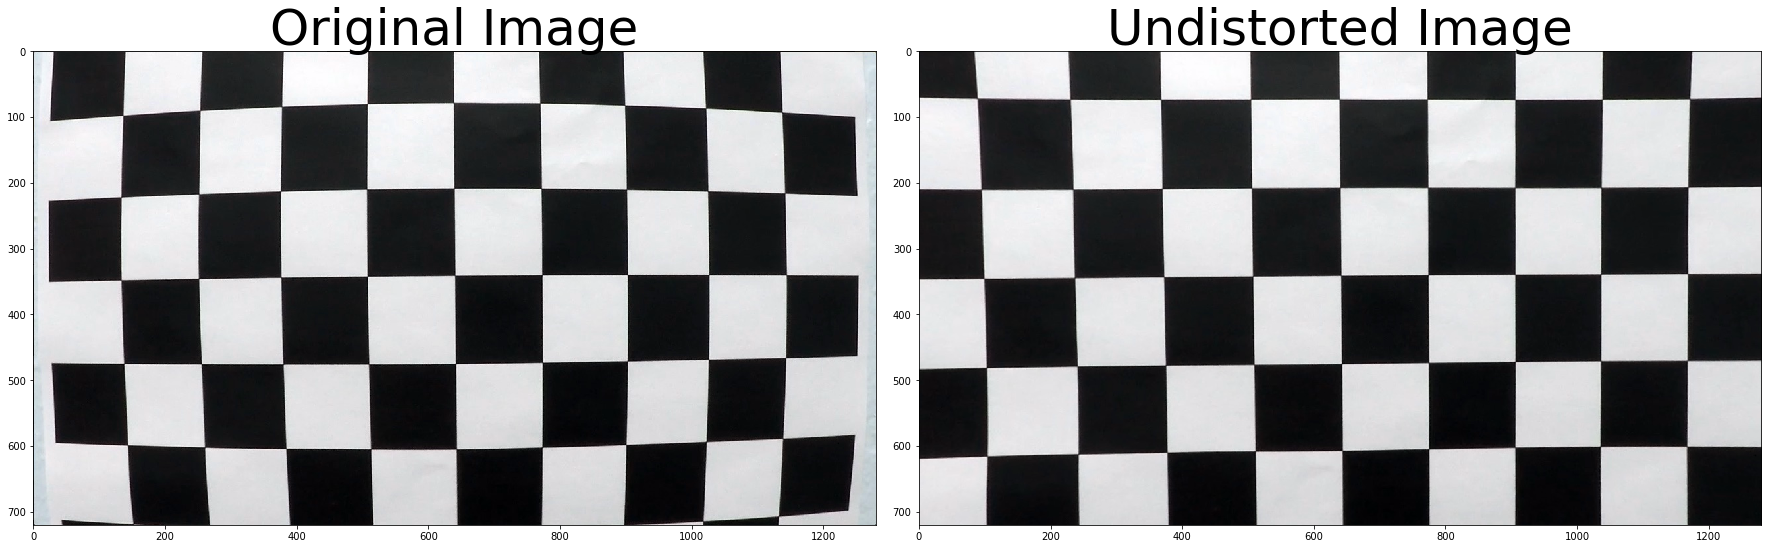

In [4]:
# Undistort a test image
img = cv2.imread('./camera_cal/calibration1.jpg')

undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

def plotImageCompare(original, firstTitle, undistorted, secondTitle):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(original)
    ax1.set_title(firstTitle, fontsize=50)
    ax2.imshow(undistorted)
    ax2.set_title(secondTitle, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
plotImageCompare(img, "Original Image", undistorted_img, "Undistorted Image")

## Creating a binary image with clear lane lines

In [5]:
# Load a test image, convert to RGB and undistort it
img = cv2.imread('./test_images/test1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#Now that we have undistortion matrices, we just plug them in:
img = cv2.undistort(img, mtx, dist, None, mtx)

In the following process, we are combining two computer vision gradient and color isolation techniques. We ar first using the Sobel operator in the x direction which gives the gradient 

In [6]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    combined = np.zeros_like(s_channel)
    combined[((sxbinary == 1)) | ((s_binary == 1))] = 1

    

    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return combined

In [7]:
imgBinary = pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100))

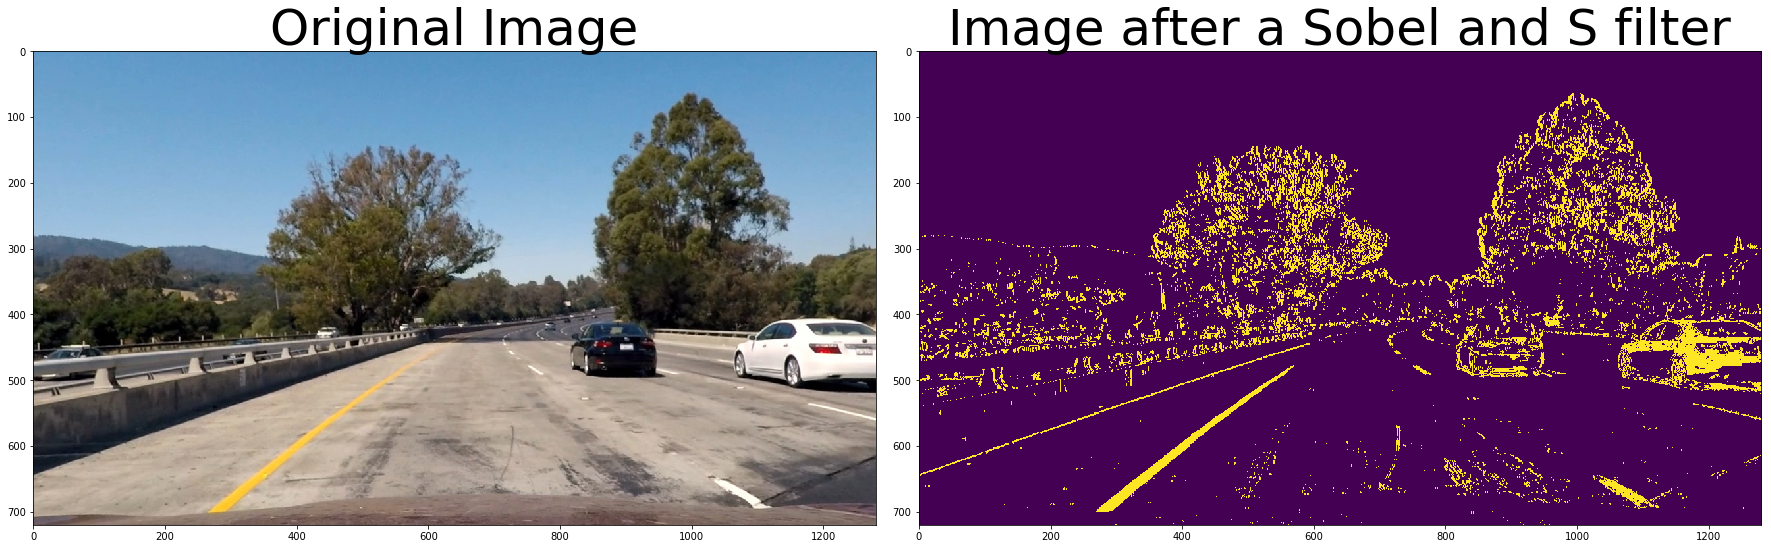

In [8]:
plotImageCompare(img,"Original Image", imgBinary, "Image after a Sobel and S filter")

## Changing the perspective:

In [9]:
def perspective_change(img, src=None, dst=None):
    # Define calibration box in source (original) and destination (desired or warped) coordinates
    img_size = (img.shape[1], img.shape[0])
    
    #The src coordinates will be a trapezoid:
    if src is None:
        src = np.float32(
            [[280,  700],  # Bottom left
             [595,  460],  # Top left
             [725,  460],  # Top right
             [1125, 700]]) # Bottom right # Bottom right
    
    
    if dst is None:
        dst = np.float32(
            [[250,  720],  # Bottom left
             [250,    0],  # Top left
             [1065,   0],  # Top right
             [1065, 720]]) # Bottom right   

    # Compute the perspective transfor, M
    M = cv2.getPerspectiveTransform(src, dst)

    
    # Compute the inverse perspective transfor also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, M, Minv

In [10]:
warped_img, _ , Minv  = perspective_change(img)


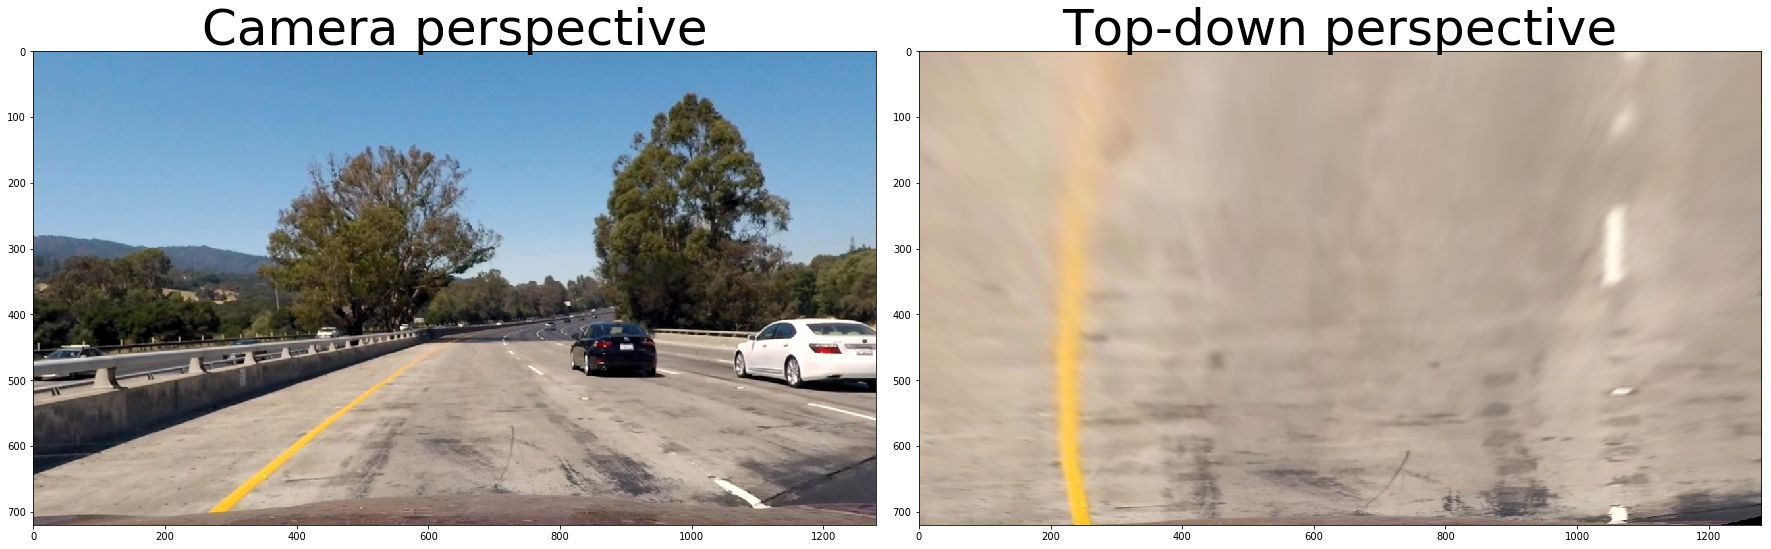

In [11]:
plotImageCompare(img,"Camera perspective", warped_img, "Top-down perspective")

In [12]:
def hist(img):
    bottom_half = img[img.shape[0]//2:,:]
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram


2


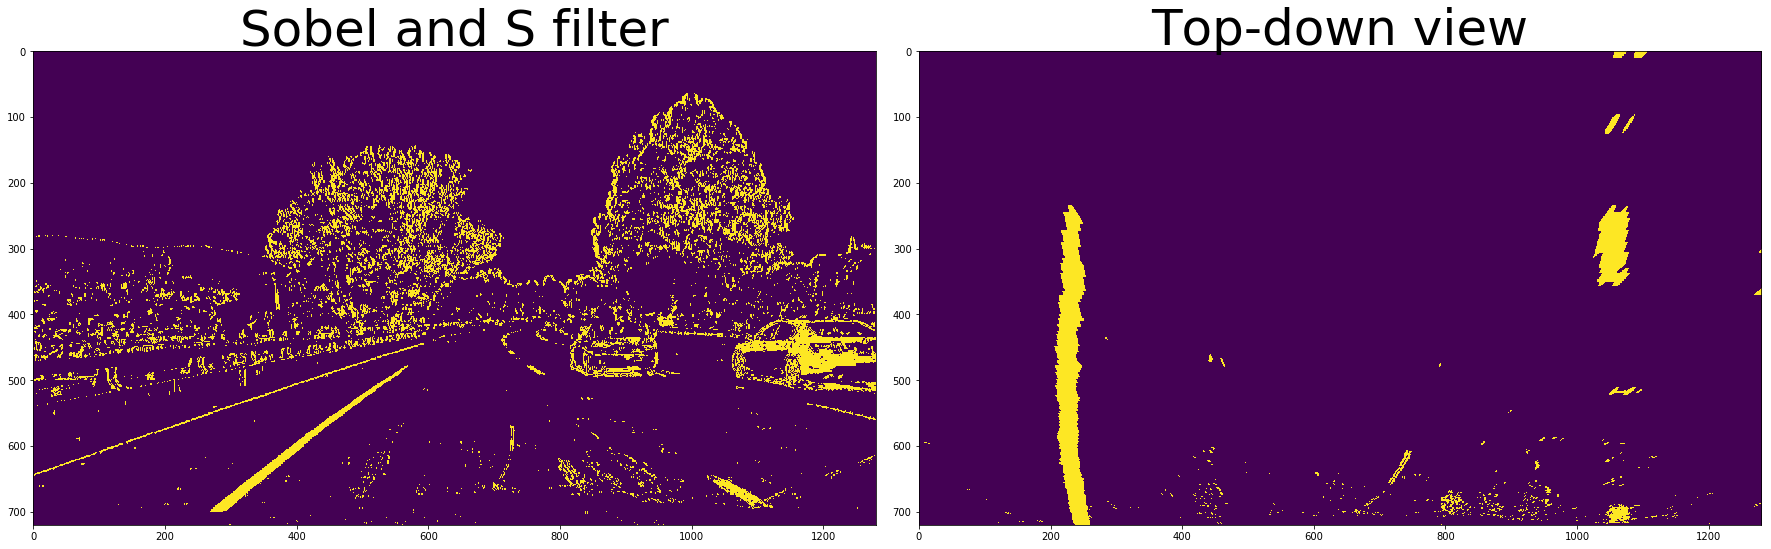

In [31]:
binary_warped, _ , Minv  = perspective_change(imgBinary)
plotImageCompare(imgBinary, "Sobel and S filter", warped_img, "Top-down view")
histimg = hist(warped_img)

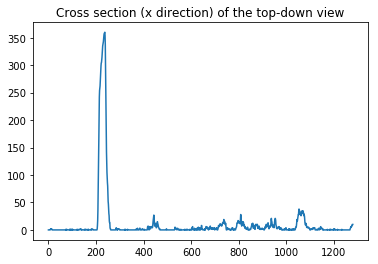

In [17]:
plt.title("Cross section (x direction) of the top-down view")
plt.plot(histimg)

In [78]:
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

# Load our image

def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    if (len(binary_warped.shape) == 2):
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    else:
        out_img= binary_warped
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
        pass # Remove this when you add your function

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')

    return out_img, ploty, left_fitx, right_fitx


out_img = fit_polynomial(binary_warped)[0]


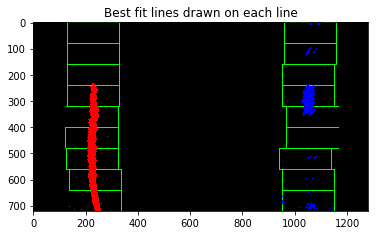

In [79]:
# Run the function
out_img, ploty, left_fitx, right_fitx = fit_polynomial(warped_img)


# Plot the results
plt.title("Best fit lines drawn on each line")
plt.imshow(out_img)

## Measuring Curvature

In [77]:
def measure_curvature_real(img):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    leftx, lefty, rightx, righty, _ = find_lane_pixels(img)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
        
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_curverad = np.power((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2),3/2)/np.absolute(2*left_fit_cr[0])  ## Implement the calculation of the left line here
    right_curverad = np.power((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2),3/2)/np.absolute(2*right_fit_cr[0])  ## Implement the calculation of the right line here
    
    return left_curverad, right_curverad


# Calculate the radius of curvature in meters for both lane lines
left_curverad, right_curverad = measure_curvature_real(binary_warped)

print(left_curverad, 'm', right_curverad, 'm')
# Should see values of 533.75 and 648.16 here, if using
# the default `generate_data` function with given seed number

3
_
3
_
3
_
3
_
3
_
3
_
3
_
3
_
3
_
658.847259716 m 1448.60360174 m


In [92]:
def draw_region(img, warped_img, left_fitx, right_fitx, ploty, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    print("right_fitx shape: "+ str(right_fitx.shape))
    print("left_fitx shape: "+ str(left_fitx.shape))
    print("ploty shape: "+ str(ploty.shape))

    # Draw the lane onto the warped blank image
    print("Color_warp shape: " + str(color_warp.shape))
    print("pts shape: " + str(pts.shape))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    print("_")
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    return cv2.addWeighted(img, 1, newwarp, 0.3, 0)

In [86]:
print("right_fitx shape: "+ str(right_fitx.shape))
print("left_fitx shape: "+ str(left_fitx.shape))
print("ploty shape: "+ str(ploty.shape))

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)


right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 3)
pts shape: (1, 1440, 2)
_


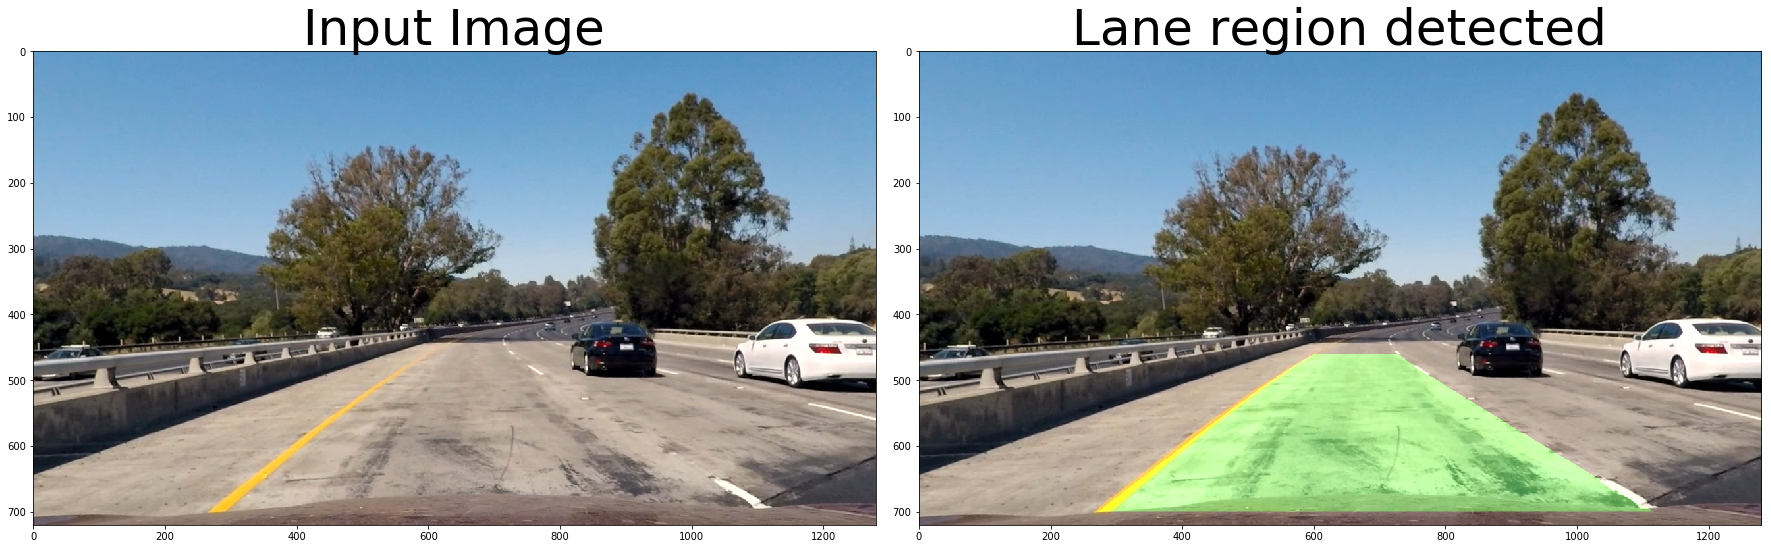

In [93]:
# Run the function
img_lane = draw_region(img, warped_img, left_fitx, right_fitx, ploty, Minv)

# Plot the results
plotImageCompare(img, 'Input Image', img_lane, 'Lane region detected')

In [81]:
def processImage(img):
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # Finding the lane lines with Sobel filter and S filter
        combined = pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100))
        
        
#         src = np.float32(
#             [[280,  700],  # Bottom left
#              [595,  460],  # Top left
#              [725,  460],  # Top right
#              [1125, 700]]) # Bottom right

#         dst = np.float32(
#             [[250,  720],  # Bottom left
#              [250,    0],  # Top left
#              [1065,   0],  # Top right
#              [1065, 720]]) # Bottom right   

        # Now let us change the perspective. We will apply a transformation to our image to get a top-down view.
        src = None
        dst = None
        
        binary_warped, _, Minv = perspective_change(combined, src, dst)
        _, ploty, left_fitx, right_fitx = fit_polynomial(binary_warped)

        
        
        # Warp the detected lane boundaries back onto the original image.
        warped_img, _, Minv = perspective_change(img, src, dst)
        
        img_lane = draw_region(img, warped_img, left_fitx, right_fitx, ploty, Minv)
            
            
        return img_lane

In [82]:
class ImageProcessing:
    def __init__(self, images):
        # List out the images
        images = glob.glob(images)
        
        # Get camera calibration matrices
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = camera_calibration(images, 9, 6)
        #self.lines_fit_left = None
        #self.lines_fit_right = None

    def __call__(self, img):
        # Undistord the image
        img = glob.glob(img)
        img = cv2.undistort(img, mtx, dist, None, mtx)

        # Finding the lane lines with Sobel filter and S filter
        combined = pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100))
        
        
#         src = np.float32(
#             [[280,  700],  # Bottom left
#              [595,  460],  # Top left
#              [725,  460],  # Top right
#              [1125, 700]]) # Bottom right

#         dst = np.float32(
#             [[250,  720],  # Bottom left
#              [250,    0],  # Top left
#              [1065,   0],  # Top right
#              [1065, 720]]) # Bottom right   

        # Now let us change the perspective. We will apply a transformation to our image to get a top-down view.
        src = None
        dst = None
        
        binary_warped, _, Minv = perspective_change(combined, src, dst)
        _, ploty, left_fitx, right_fitx = fit_polynomial(binary_warped)

        
        
        # Warp the detected lane boundaries back onto the original image.
        warped_img, _, Minv = perspective_change(img, src, dst)
        
        img_lane = draw_region(img, warped_img, left_fitx, right_fitx, ploty, Minv)
            
            
        return img_lane

In [94]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'

white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip(input_video).subclip(0,5)
white_clip = clip1.fl_image(processImage) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 9)
pts shape: (1, 1440, 2)


error: OpenCV(4.0.0) /io/opencv/modules/core/src/array.cpp:3229: error: (-215:Assertion failed) cn <= 4 in function 'scalarToRawData'


In [95]:
input_video = './project_video.mp4'
output_video = './project_video_solution.mp4'


clip1 = VideoFileClip(input_video)

# Process video frames with our 'process_image' function
process_image = ImageProcessing('./camera_cal/calibration*.jpg')

white_clip = clip1.fl_image(processImage)

%time white_clip.write_videofile(output_video, audio=False)

Successfully calibrated.
right_fitx shape: (720,)
left_fitx shape: (720,)
ploty shape: (720,)
Color_warp shape: (720, 1280, 9)
pts shape: (1, 1440, 2)


error: OpenCV(4.0.0) /io/opencv/modules/core/src/array.cpp:3229: error: (-215:Assertion failed) cn <= 4 in function 'scalarToRawData'
